In [1]:
import glob
import json
import pandas as pd
import os
import re
import ast

def parse_all_logs_to_csv(logs_dir='../logs/', output_file='all_game_logs.csv'):
    """
    Parses all .jsonl log files in the specified directory and creates a comprehensive CSV dataset.
    """
    log_files = glob.glob(os.path.join(logs_dir, '*.jsonl'))
    
    if not log_files:
        print("No log files found.")
        return pd.DataFrame()
        
    all_records = []
    
    print(f"Processing {len(log_files)} log files...")
    
    for log_file in log_files:
        session_id = os.path.basename(log_file).replace('.jsonl', '')
        
        # State tracking for this session
        current_round = 0
        player_roles = {}
        
        with open(log_file, 'r') as f:
            for line_num, line in enumerate(f):
                try:
                    entry = json.loads(line)
                except json.JSONDecodeError:
                    continue
                
                # Base record
                record = {
                    'session_id': session_id,
                    'line_number': line_num + 1,
                    'timestamp': entry.get('timestamp'),
                    'type': entry.get('type'),
                    'level': entry.get('level'),
                    'raw_message': entry.get('message'),
                }
                
                data = entry.get('data', {})
                
                # Extract Round
                if entry.get('type') == 'system':
                    msg = data.get('message', '')
                    if '--- Round' in msg:
                        match = re.search(r'--- Round (\d+) ---', msg)
                        if match:
                            current_round = int(match.group(1))
                    
                    # Extract Roles
                    if 'Roles (SECRET):' in msg:
                        try:
                            roles_str = msg.split('Roles (SECRET):')[1].strip()
                            # It looks like a python dict string: {'Alice': 'Loyalist', ...}
                            player_roles = ast.literal_eval(roles_str)
                        except Exception as e:
                            print(f"Error parsing roles in {log_file}: {e}")

                record['round'] = current_round
                
                # Flatten data fields
                # Common fields
                record['player'] = data.get('player')
                
                # Add role if player is known
                if record['player'] and record['player'] in player_roles:
                    record['role'] = player_roles[record['player']]
                else:
                    record['role'] = None

                # Specific fields based on type
                record['action'] = data.get('action')
                record['action_details'] = data.get('details')
                record['speech'] = data.get('speech')
                record['thought'] = data.get('thought')
                record['game_event'] = data.get('event')
                
                all_records.append(record)
    
    df = pd.DataFrame(all_records)
    
    # Reorder columns for better readability
    cols = ['session_id', 'round', 'timestamp', 'type', 'player', 'role', 'action', 'action_details', 'speech', 'thought', 'game_event', 'raw_message']
    
    # Ensure all columns exist (in case some logs didn't have certain events)
    for col in cols:
        if col not in df.columns:
            df[col] = None
            
    # Select and reorder
    df = df[cols]
    
    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Successfully created dataset with {len(df)} rows in '{output_file}'")
    return df

# Generate the dataset
df = parse_all_logs_to_csv()
df.head(n=10)

Processing 8 log files...
Successfully created dataset with 3701 rows in 'all_game_logs.csv'
Successfully created dataset with 3701 rows in 'all_game_logs.csv'


,session_id,round,timestamp,type,player,role,action,action_details,speech,thought,game_event,raw_message
0,game_session_20251206_125649,0,"2025-12-06 12:56:49,946",system,None,None,None,None,None,None,None,[37m[SYSTEM][0m Game Setup Complete. Players...
1,game_session_20251206_125649,0,"2025-12-06 12:56:49,948",system,None,None,None,None,None,None,None,[37m[SYSTEM][0m Roles (SECRET): {'Alice': 'L...
2,game_session_20251206_125649,0,"2025-12-06 12:56:49,949",system,None,None,None,None,None,None,None,[37m[SYSTEM][0m Starting Game Session...
3,game_session_20251206_125649,0,"2025-12-06 12:56:49,950",system,None,None,None,None,None,None,None,[37m[SYSTEM][0m Game state saved to last_gam...
4,game_session_20251206_125649,1,"2025-12-06 12:56:49,950",system,None,None,None,None,None,None,None,[37m[SYSTEM][0m --- Round 1 ---
5,game_session_20251206_125649,1,"2025-12-06 12:56:49,950",game_event,None,None,None,None,None,None,President is Alice,[33m[GAME][0m President is Alice
6,game_session_20251206_125649,1,"2025-12-06 12:56:58,092",thought,Alice,Loyalist,None,None,None,"1. **Analysis:** I am Alice, a Loyalist. This...",None,[35m[THOUGHT][0m Alice: (Internal) 1. **Ana...
7,game_session_20251206_125649,1,"2025-12-06 12:56:58,092",action,Alice,Loyalist,Nominated,Bob,None,None,None,[36m[ACTION][0m Alice: Nominated - Bob
8,game_session_20251206_125649,1,"2025-12-06 12:56:58,092",game_event,None,None,None,None,None,None,President Alice nominates Bob for Chancellor.,[33m[GAME][0m President Alice nominates Bob ...
9,game_session_20251206_125649,1,"2025-12-06 12:56:58,092",system,None,None,None,None,None,None,None,[37m[SYSTEM][0m --- Discussion Round 1 ---


In [2]:
# Extract Winner
def extract_winner(df):
    winners = []
    for session_id in df['session_id'].unique():
        session_df = df[df['session_id'] == session_id]
        
        # Look for Game Over message
        game_over_msgs = session_df[
            (session_df['type'] == 'system') & 
            (session_df['raw_message'].str.contains('GAME OVER', na=False))
        ]
        
        winner = "Unknown"
        if not game_over_msgs.empty:
            msg = game_over_msgs.iloc[-1]['raw_message']
            if "Winner: Liberals" in msg:
                winner = "Liberals"
            elif "Winner: Fascists" in msg: # Assuming Fascists based on standard SH, but let's check if it says Spies or Fascists
                winner = "Spies" # Based on logs seen earlier (Loyalist/Spy)
            elif "Winner: Spies" in msg:
                winner = "Spies"
            elif "Winner: Loyalists" in msg:
                winner = "Loyalists"
            else:
                # Try to parse from string if format is "Winner: <Team>"
                try:
                    winner = msg.split("Winner: ")[1].strip()
                    # Remove color codes if present
                    winner = re.sub(r'\x1b\[[0-9;]*m', '', winner)
                except:
                    pass
        
        winners.append({'session_id': session_id, 'winner': winner})
    
    return pd.DataFrame(winners)

winners_df = extract_winner(df)
print(winners_df['winner'].value_counts())
winners_df.head()

winner
Spies        3
Unknown      3
Loyalists    2
Name: count, dtype: int64


,session_id,winner
0,game_session_20251206_125649,Loyalists
1,game_session_20251204_193220,Spies
2,game_session_20251204_172554,Unknown
3,game_session_20251204_191939,Unknown
4,game_session_20251205_191112,Loyalists


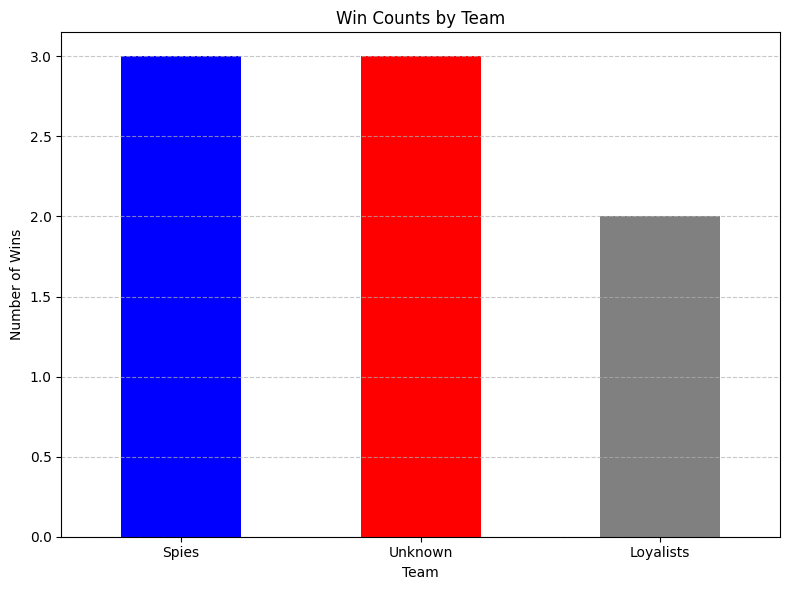

Win Percentages:
winner
Spies        37.5
Unknown      37.5
Loyalists    25.0
Name: count, dtype: float64


In [3]:
import matplotlib.pyplot as plt
import os

# Ensure local figures directory
FIG_DIR = 'figures'
os.makedirs(FIG_DIR, exist_ok=True)

# Win Rate Analysis
win_counts = winners_df['winner'].value_counts()

plt.figure(figsize=(8, 6))
win_counts.plot(kind='bar', color=['blue', 'red', 'gray'])
plt.title('Win Counts by Team')
plt.xlabel('Team')
plt.ylabel('Number of Wins')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'figure_01_win_counts.png'), dpi=200)
plt.show()

# Calculate percentages
win_pct = win_counts / win_counts.sum() * 100
print("Win Percentages:")
print(win_pct)

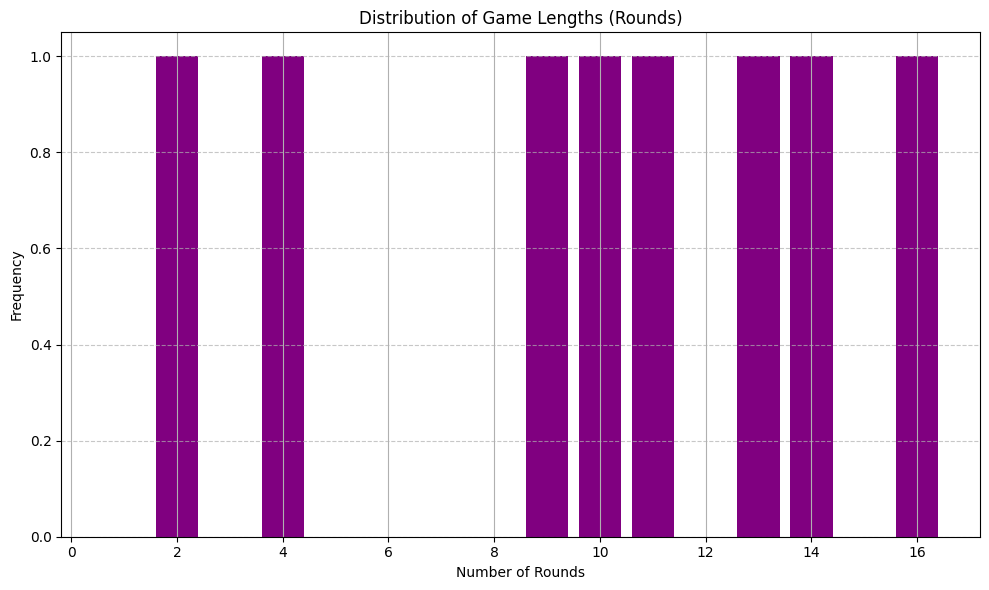

Average Game Length: 9.88 rounds
Min Game Length: 2 rounds
Max Game Length: 16 rounds


In [4]:
# Game Length Analysis (Rounds)
import os
FIG_DIR = 'figures'
os.makedirs(FIG_DIR, exist_ok=True)

game_lengths = df.groupby('session_id')['round'].max()

plt.figure(figsize=(10, 6))
game_lengths.hist(bins=range(1, game_lengths.max() + 2), align='left', rwidth=0.8, color='purple')
plt.title('Distribution of Game Lengths (Rounds)')
plt.xlabel('Number of Rounds')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'figure_02_round_histogram.png'), dpi=200)
plt.show()

print(f"Average Game Length: {game_lengths.mean():.2f} rounds")
print(f"Min Game Length: {game_lengths.min()} rounds")
print(f"Max Game Length: {game_lengths.max()} rounds")

Vote Counts by Role:
action_details   Ja  Nein
role                     
Loyalist        136   153
Master Spy       54    27
Spy              91    35

Vote Percentages by Role:
action_details         Ja       Nein
role                                
Loyalist        47.058824  52.941176
Master Spy      66.666667  33.333333
Spy             72.222222  27.777778


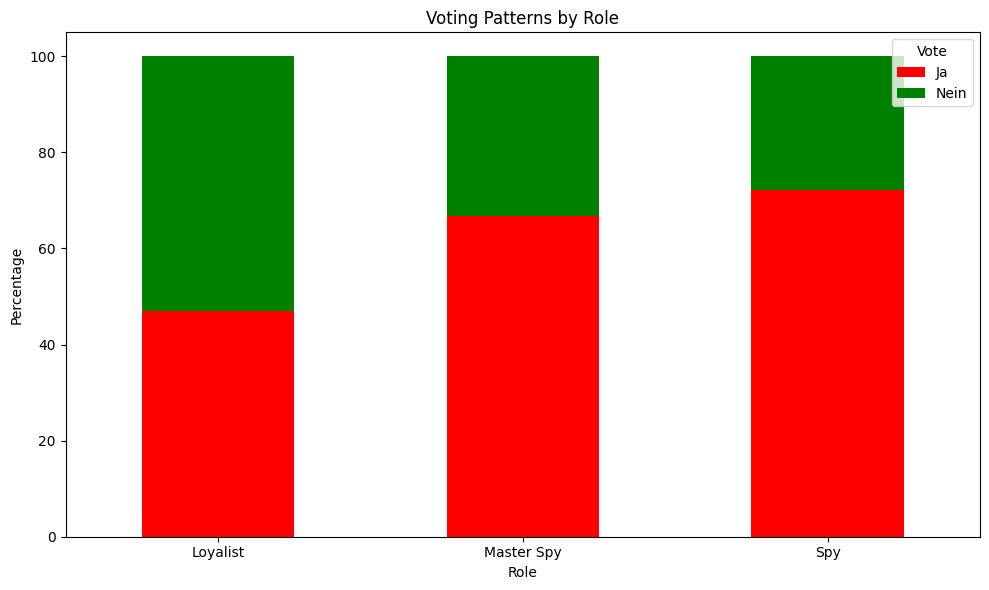

In [5]:
# Voting Analysis
import os
FIG_DIR = 'figures'
os.makedirs(FIG_DIR, exist_ok=True)

# Filter for voting actions
votes_df = df[df['action'] == 'Voted'].copy()

if not votes_df.empty:
    # Group by Role and Vote
    vote_counts = votes_df.groupby(['role', 'action_details']).size().unstack(fill_value=0)
    
    # Calculate percentages
    vote_pct = vote_counts.div(vote_counts.sum(axis=1), axis=0) * 100
    
    print("Vote Counts by Role:")
    print(vote_counts)
    print("\nVote Percentages by Role:")
    print(vote_pct)
    
    # Plot
    ax = vote_pct.plot(kind='bar', stacked=True, figsize=(10, 6), color=['red', 'green'])
    plt.title('Voting Patterns by Role')
    plt.xlabel('Role')
    plt.ylabel('Percentage')
    plt.legend(title='Vote')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'figure_03_voting_patterns.png'), dpi=200)
    plt.show()
else:
    print("No voting data found.")

Total Speeches by Role:
role
Loyalist      430
Master Spy    125
Spy           185
dtype: int64

Average Speeches per Game by Role (Total for all players of that role):
role
Loyalist      53.750
Master Spy    15.625
Spy           23.125
dtype: float64

Roles found: ['Loyalist' 'Master Spy' 'Spy']


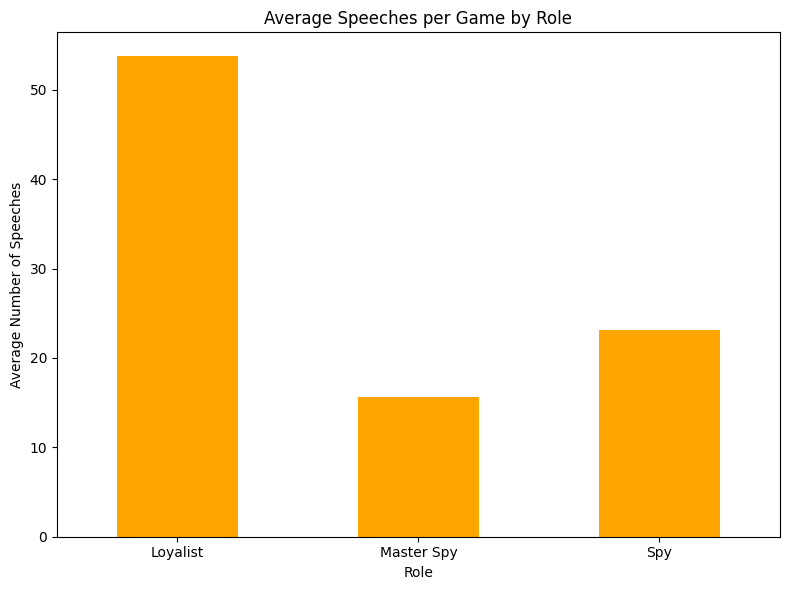

In [6]:
# Speech Analysis
import os
FIG_DIR = 'figures'
os.makedirs(FIG_DIR, exist_ok=True)

# Count number of speeches per player per session
speech_df = df[df['type'] == 'speech'].copy()

if not speech_df.empty:
    # Group by Role and count
    speech_counts = speech_df.groupby('role').size()
    
    print("Total Speeches by Role:")
    print(speech_counts)
    
    # Average speeches per game per role
    num_games = df['session_id'].nunique()
    avg_speech_per_game = speech_counts / num_games
    
    print("\nAverage Speeches per Game by Role (Total for all players of that role):")
    print(avg_speech_per_game)
    
    unique_roles = df['role'].dropna().unique()
    print(f"\nRoles found: {unique_roles}")
    
    plt.figure(figsize=(8, 6))
    avg_speech_per_game.plot(kind='bar', color='orange')
    plt.title('Average Speeches per Game by Role')
    plt.xlabel('Role')
    plt.ylabel('Average Number of Speeches')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'figure_04_speech_avg.png'), dpi=200)
    plt.show()
else:
    print("No speech data found.")

Policy Enactments by Chancellor Role:
action_details  Blue  Red
role                     
Loyalist          11   12
Master Spy         6    4
Spy                2    5


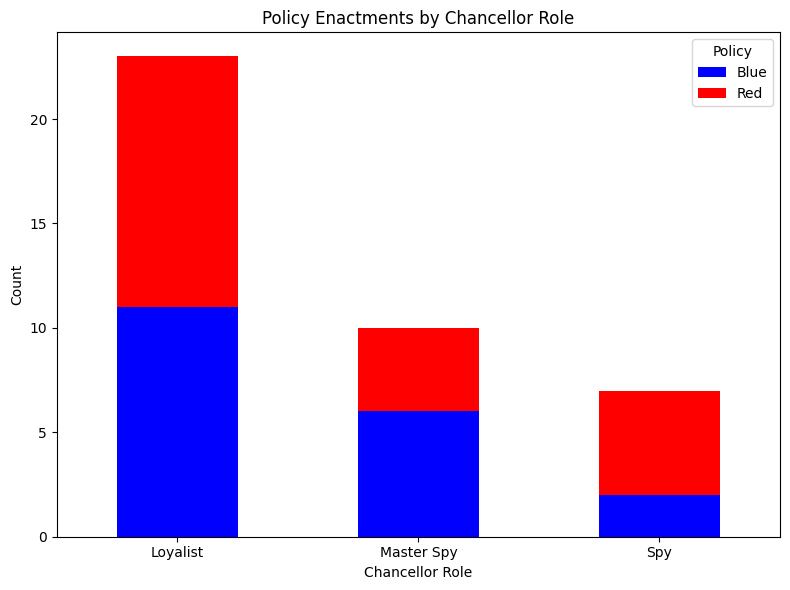

In [7]:
# Policy Enactment Analysis
import os
FIG_DIR = 'figures'
os.makedirs(FIG_DIR, exist_ok=True)

# Analyze which policies are enacted by which roles
enactments_df = df[df['action'] == 'Enacted'].copy()

if not enactments_df.empty:
    enactment_counts = enactments_df.groupby(['role', 'action_details']).size().unstack(fill_value=0)
    
    print("Policy Enactments by Chancellor Role:")
    print(enactment_counts)
    
    colors = []
    if 'Blue' in enactment_counts.columns: colors.append('blue')
    if 'Red' in enactment_counts.columns: colors.append('red')
    
    ax = enactment_counts.plot(kind='bar', stacked=True, color=colors, figsize=(8, 6))
    plt.title('Policy Enactments by Chancellor Role')
    plt.xlabel('Chancellor Role')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend(title='Policy')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'figure_05_enactments.png'), dpi=200)
    plt.show()
else:
    print("No enactment data found.")

Nomination Matrix (Row=Nominator, Col=Nominee):
nominee_role  Loyalist  Master Spy  Spy
role                                   
Loyalist            37           6   17
Master Spy          10           0    4
Spy                  5          11    7


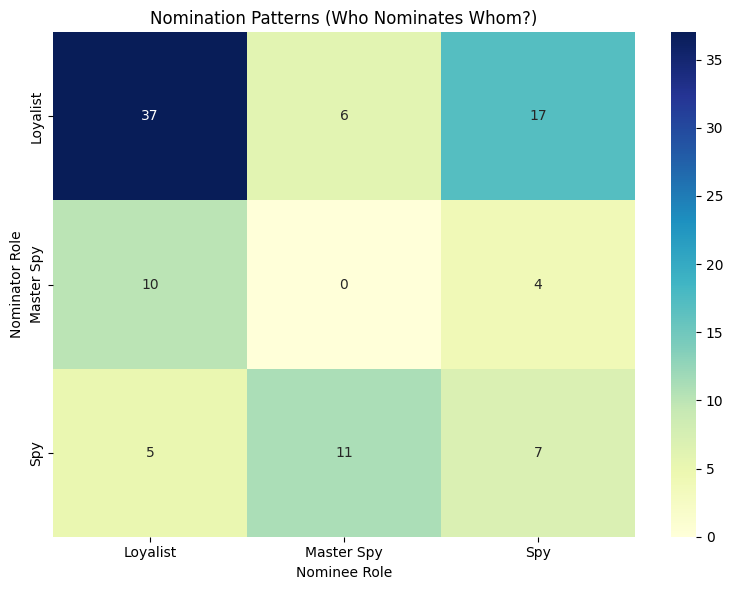


Nomination Percentages (Row-wise):
nominee_role   Loyalist  Master Spy        Spy
role                                          
Loyalist      61.666667   10.000000  28.333333
Master Spy    71.428571    0.000000  28.571429
Spy           21.739130   47.826087  30.434783


In [8]:
import seaborn as sns
import os
FIG_DIR = 'figures'
os.makedirs(FIG_DIR, exist_ok=True)

# Nomination Patterns
nominations_df = df[df['action'] == 'Nominated'].copy()

if not nominations_df.empty:
    player_role_map = df[['session_id', 'player', 'role']].dropna().drop_duplicates()
    player_role_map = player_role_map.rename(columns={'player': 'nominee_name', 'role': 'nominee_role'})
    
    nominations_with_roles = pd.merge(
        nominations_df, 
        player_role_map, 
        left_on=['session_id', 'action_details'], 
        right_on=['session_id', 'nominee_name'],
        how='left'
    )
    
    nomination_matrix = nominations_with_roles.groupby(['role', 'nominee_role']).size().unstack(fill_value=0)
    
    print("Nomination Matrix (Row=Nominator, Col=Nominee):")
    print(nomination_matrix)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(nomination_matrix, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Nomination Patterns (Who Nominates Whom?)')
    plt.ylabel('Nominator Role')
    plt.xlabel('Nominee Role')
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'figure_06_nominations_heatmap.png'), dpi=200)
    plt.show()
    
    nomination_pct = nomination_matrix.div(nomination_matrix.sum(axis=1), axis=0) * 100
    print("\nNomination Percentages (Row-wise):")
    print(nomination_pct)

else:
    print("No nomination data found.")

Average Word Count by Role:
role
Loyalist      136.672093
Master Spy    135.400000
Spy           146.978378
Name: word_count, dtype: float64


/tmp/ipykernel_65882/3613492581.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='role', y='word_count', data=speech_df, palette="Set3")


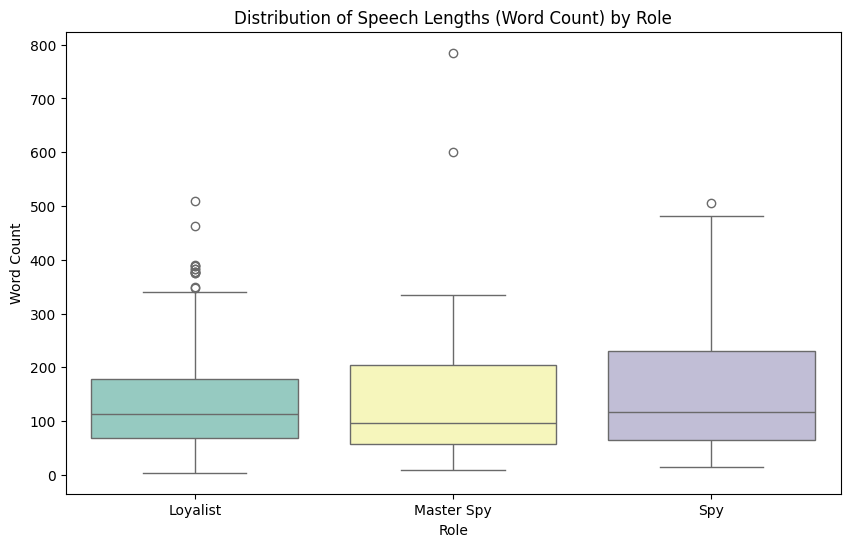

In [9]:
# Speech Length Analysis
# Analyze the verbosity of different roles

speech_df = df[df['type'] == 'speech'].copy()

if not speech_df.empty:
    # Calculate word count
    speech_df['word_count'] = speech_df['speech'].apply(lambda x: len(str(x).split()))
    
    print("Average Word Count by Role:")
    print(speech_df.groupby('role')['word_count'].mean())
    
    # Boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='role', y='word_count', data=speech_df, palette="Set3")
    plt.title('Distribution of Speech Lengths (Word Count) by Role')
    plt.xlabel('Role')
    plt.ylabel('Word Count')
    plt.show()
else:
    print("No speech data found.")